In [37]:
# Show all Jupyter cell outputs, NOT just the last cell's output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import re
import string
from random import randint

from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from collections import Counter

from matplotlib import style
style.use("ggplot")

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score,f1_score
from sklearn.linear_model import LogisticRegression

from sklearn import svm


In [38]:
# Use pandas to pluck out abstracts
search_results = pd.read_excel('searchResult.xlsx')


In [39]:
search_results.columns
search_results.head(20)

Index(['Category', 'title', 'link', 'excerpt'], dtype='object')

,Category,title,link,excerpt
0,useful,Zambia Population (2019) - Worldometers,https://www.worldometers.info/world-population...,"Population of Zambia: current, historical, and..."
1,useful,Zambia Population | 2019 | Data | Chart | Cale...,https://tradingeconomics.com/zambia/population,The total population in Zambia was estimated a...
2,useful,population - Central Statistical Office of Zambia,https://www.zamstats.gov.zm/phocadownload/Diss...,Zambia in Figures- 2018 features statistical i...
3,useful,"Zambia Population 2019 (Demographics, Maps, Gr...",http://worldpopulationreview.com/countries/zam...,4 Jan 2019 ... Much of Zambia's population is ...
4,useful,Population of Cities in Zambia (2019) - World ...,http://worldpopulationreview.com/countries/zam...,Zambia has 1 cities with more than a million p...
5,useful,Live Zambia population (2019) — Countrymeters,https://countrymeters.info/en/Zambia,Live statistics for population of Zambia. Curr...
6,useful,Zambia - Population and Demography of Zambia -...,http://zambia.opendataforafrica.org/ZMPAD21016...,"Zambia. Population and Demography of Zambia, 2..."
7,useful,Population and Demography of Zambia - Zambia D...,http://zambia.opendataforafrica.org/ZMPAD21016...,"Population and Demography of Zambia, 2016. ......"
8,useful,Demographics of Zambia - Wikipedia,https://en.wikipedia.org/wiki/Demographics_of_...,According to the 2017 revision of the World Po...
9,useful,Africa :: Zambia — The World Factbook - Centra...,https://www.cia.gov/library/publications/the-w...,The name was changed to Zambia upon independen...


In [40]:
#creat new culumns for Features and targets

search_results['Xs'] =  search_results.title +' '+ search_results.link +' '+ search_results.excerpt #creat new column 'Xs'
search_results['Y'] = LabelEncoder().fit(search_results.Category.unique()).transform(search_results.Category) #label encode

#display the dataframe to show the new results.
search_results.columns
search_results.sample(20)

Index(['Category', 'title', 'link', 'excerpt', 'Xs', 'Y'], dtype='object')

,Category,title,link,excerpt,Xs,Y
71,useful,"Zambian Census, 2000",https://www.nmec.org.zm/s/popreport.pdf,Zambia. 2000. CENSUS OF POPULATION. AND HOUSIN...,"Zambian Census, 2000 https://www.nmec.org.zm/s...",1
90,useful,POPULATION EXPLOSION PUTS LUSAKA AT RISK - Dai...,https://www.zambiadailynation.com/2016/10/18/p...,18 Oct 2016 ... Zambia's population is showing...,POPULATION EXPLOSION PUTS LUSAKA AT RISK - Dai...,1
146,not useful,Challenges faced by manufacturing industries i...,http://almassar.org/3jpv/challenges-faced-by-m...,The Republic of Zambia has a total population ...,Challenges faced by manufacturing industries i...,0
53,useful,Zambia – Water & Sanitation for the Urban Poor,https://www.wsup.com/where-we-work/zambia/,Nearly half the population live in urban areas...,Zambia – Water & Sanitation for the Urban Poor...,1
44,useful,Zambia | World Food Programme,https://www1.wfp.org/countries/zambia,Zambia is a landlocked country in Southern Afr...,Zambia | World Food Programme https://www1.wfp...,1
79,useful,"Zambia | Culture, History, & People | Britanni...",https://www.britannica.com/place/Zambia,7 Mar 2019 ... Zambia: Geographical and histor...,"Zambia | Culture, History, & People | Britanni...",1
77,useful,Ministry of National Development Planning,http://www.mndp.gov.zm/,The Ministry of National Development Planning ...,Ministry of National Development Planning http...,1
93,not useful,Elephants successfully collared in Sioma Ngwez...,https://www.wwfzm.panda.org/resource_center/pr...,"3 Oct 2017 ... In Zambia, the population of el...",Elephants successfully collared in Sioma Ngwez...,0
54,useful,Zambia : PSI,https://www.psi.org/country/zambia/,"SFH Zambia: Society for Family Health, Marketi...",Zambia : PSI https://www.psi.org/country/zambi...,1
49,useful,Zambia – Water & Sanitation for the Urban Poor,https://www.wsup.com/where-we-work/zambia/,Nearly half the population live in urban areas...,Zambia – Water & Sanitation for the Urban Poor...,1


In [41]:
search_results.shape
search_results.dropna(inplace = True) #drop files with missing fields
search_results.shape

(156, 6)

(154, 6)

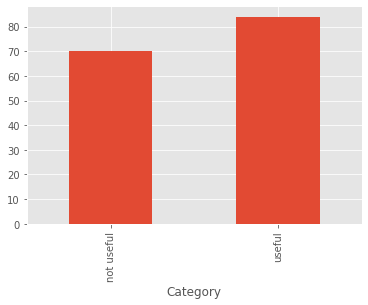

In [42]:
search_results.groupby('Category').Category.count().plot.bar()

In [43]:
# generates a dataframe of the mapping between Category and labels(Y)

lable_category = search_results[['Category','Y']].drop_duplicates().sort_values('Y').reset_index().drop(columns='index')
lable_category

,Category,Y
0,not useful,0
1,useful,1


In [44]:
# creat a list to hold the documents created above
search_results_list = list(search_results.Xs)
search_results_list[0]

'Zambia Population (2019) - Worldometers https://www.worldometers.info/world-population/zambia-population/ Population of Zambia: current, historical, and projected population, growth rate, \nimmigration, median age, total fertility rate (TFR), population density,\xa0...'

### Function definition

In [45]:

# 2. Case Folding
# Good idea to implement a function here [...]

def func_case_folding(contentText):
    return contentText.lower()

# 3. Punctuation
# Function for removing punctuations from string of text
def func_rmv_punctuation(contentText):
    
    #replace special charactors with ' '
    contentText_out = re.sub('[^\w\s]', ' ',contentText)
    contentText_out = re.sub('_', '',contentText_out)
    
    #change any whitespace to one space
    contentText_out = re.sub('\s+', ' ',contentText_out)
    
    #remove start and end whitespaces
    contentText_out = contentText_out.strip()
    
    contentText_out = re.sub('\w*\d\w*', '', contentText_out) # replace digits
    return contentText_out

# 4. Stopwords
# Function for removing stopwords from string of text
def func_rmv_stopwords(contentText_in):
    
    contentText_out = " ".join([
        contentText_word for contentText_word in contentText_in.split() 
        if contentText_word not in stopwords.words('english')
    ])
    return contentText_out

# 5. Stemming
# Function for removing stopwords from string of text
# Remember: input will be chunck of text
def func_stem(contentText):
    var_stemmer = PorterStemmer()
    contentText_out = " ".join([
        var_stemmer.stem(contentText_word) for contentText_word in contentText.split() 
    ])
    return contentText_out

# 6. form the corpus

def func_get_all_words(content_list):
    all_words = []
    for item in content_list:
        for n in item.split():
            all_words.append(n)
    return all_words
        


# function for functions to carry out step 2 to 5

def func_clean_textDocument(content_list):
    
    temp_list = []
    for item in content_list:
        itemOut = func_case_folding(item)
        itemOut = func_rmv_punctuation(itemOut)
        itemOut = func_rmv_stopwords(itemOut)
        itemOut = func_stem(itemOut)
        
        temp_list.append(itemOut)
        
    return temp_list


In [46]:
clean_search_results_list = func_clean_textDocument(search_results_list)

In [47]:
check_index = randint(0, len(search_results_list))

len(search_results_list[check_index])
search_results_list[check_index]

len(clean_search_results_list[check_index])
clean_search_results_list[check_index]

255

'Zambia - Convention on Biological Diversity (CBD) https://www.cbd.int/doc/world/zm/zm-nr-01-en.pdf 28 May 1993 ... Environmental Conservation Association of Zambia. ECZ. Environmental .... The \npopulation of Zambia is estimated at 9.2 million (CSO, 1996).'

160

'zambia convent biolog divers cbd http www cbd int doc world zm zm nr en pdf may environment conserv associ zambia ecz environment popul zambia estim million cso'

#### Inspect the words

In [48]:
#checking the frequence of the most common top 10 words
Counter(func_get_all_words(clean_search_results_list)).most_common(20)

[('zambia', 347),
 ('popul', 242),
 ('http', 154),
 ('www', 100),
 ('com', 60),
 ('org', 59),
 ('world', 49),
 ('countri', 33),
 ('nation', 27),
 ('peopl', 24),
 ('zambian', 24),
 ('health', 24),
 ('day', 24),
 ('zm', 23),
 ('pdf', 23),
 ('growth', 22),
 ('ago', 22),
 ('live', 21),
 ('html', 21),
 ('data', 20)]

#### Produce Feature extraction

In [49]:
vectorizer = TfidfVectorizer()
vectorizer.fit(clean_search_results_list)
features = vectorizer.transform(clean_search_results_list)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [50]:
feature_columns = vectorizer.get_feature_names()
len(feature_columns)

1269

In [51]:
feature_df = pd.DataFrame(features.toarray(), columns = feature_columns)
feature_df.sample(20)

,ab,academ,academi,acca,accaglob,acceler,access,accord,account,ad,...,zani,zda,zema,zimbabw,zinc,zm,zmb,zmfact,znphi,окт
35,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
148,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
75,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
122,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.143145,0.0,0.0,0.0,0.0
131,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
14,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
87,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.116657,0.0,0.0,0.0,0.0
80,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
86,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.378278,0.0,0.0,0.0,0.000000,0.111228,0.0,0.0,0.0,0.0
51,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


#### Train - Test Split

In [52]:
#train_test_split?
x_train, x_test, y_train, y_test = train_test_split(feature_df, search_results['Y'], test_size=0.20)
len(x_train)
len(x_test)

123

31

##### The training and the test the model

In [53]:
#isntatiate the model, 


#svm_model = LogisticRegression()

model = LinearSVC()

In [54]:
# Performing parameters fitting for best LinearSVC fit 



model.fit(x_train, y_train)


#svm_model.fit(x_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [55]:
model.score(x_test, y_test)

#svm_model.score(x_test,y_test)

0.7419354838709677

In [56]:
y_pred = model.predict(x_test)



#y_pred = svm_model.predict(x_test)

print('Predicted: '+ str(y_pred))
print('Actual:    '+ str(np.array(y_test)))

Predicted: [0 1 1 1 0 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1]
Actual:    [0 1 0 1 0 1 1 0 0 1 1 0 0 0 1 1 1 1 0 1 1 0 0 0 0 1 1 0 1 1 1]


#### confusion matrix

In [57]:
conf_mat = confusion_matrix(y_test, y_pred)

TP = conf_mat[1, 1]
TN = conf_mat[0, 0]
FP = conf_mat[0, 1]
FN = conf_mat[1, 0]


Text(33.0, 0.5, 'Actual')

Text(0.5, 15.0, 'Predicted')

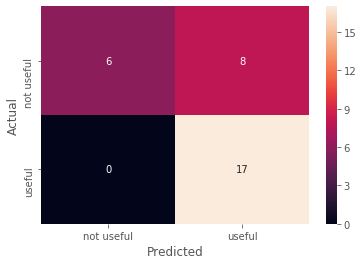

In [58]:
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=lable_category.Category.values, yticklabels=lable_category.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [59]:
# use float to perform true division, not integer division
print('Accuracy:')
print((TP + TN) / float(TP + TN + FP + FN))
print(accuracy_score(y_test, y_pred))

Accuracy:
0.7419354838709677
0.7419354838709677


In [60]:
sensitivity = TP / float(FN + TP)
print('Sensitivity or Recall or True Positive rate: ')
print(sensitivity)
print(recall_score(y_test, y_pred))

Sensitivity or Recall or True Positive rate: 
1.0
1.0


In [61]:
specificity = TN / (TN + FP)

print('specificity: '+ str(specificity))

specificity: 0.42857142857142855


In [62]:
precision = TP / float(TP + FP)

print('Precision: ')
print(precision)
print(precision_score(y_test, y_pred))

Precision: 
0.68
0.68


In [63]:
f1_score_ = (2*precision*sensitivity)/ float(precision + sensitivity)

print('f1-Score: ')
print(f1_score_)
print(f1_score(y_test, y_pred))


f1-Score: 
0.8095238095238095
0.8095238095238095


#### cross-validation, k-folds

In [64]:
scores = cross_val_score(model,feature_df, search_results['Y'], cv=10, scoring='accuracy')
scores.mean()

0.8012500000000001